In this notebook, a Word2Vec model with skip grams is built from scratch. Then the embedding layer from the Word2vec model is used to build end-to-end word prediction model that called as 'word_prediction_model'

All the datasets' size is reduced, you may access them in [here](https://drive.google.com/drive/folders/1vhaYmyeMfsfOEd0hM6N-I8-eL-zZ4C7f?usp=sharing)



Group members:
1. Foo Ling Zhen 158799
2. Khoo Jia Xin 158764

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Reshape, Concatenate
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.sequence import skipgrams
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.models import Word2Vec
import multiprocessing
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


In [31]:
!pip install gensim
!pip install tensorflow


In [32]:
# Open the file in read mode with UTF-8 encoding
def read_text(text_path):

#remove the last element of the list (the empty string due to trailing newline at the end of file)
 return open(text_path, "r", encoding="utf8").read().split("\n")[:-1]

train_data = read_text("/kaggle/input/353-dataset/train.txt")
test_data = read_text("/kaggle/input/353-dataset/test.txt")
valid_data = read_text("/kaggle/input/353-dataset/valid.txt")

In [33]:
# Assuming n=10 and vocabulary size is set to 10,000 words
n = 10
vocab_size = 10000


In [34]:
# Tokenization
malay_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
malay_tokenizer.fit_on_texts(train_data)

# Convert sentences to lists of words
train_sequences = [sentence.split() for sentence in train_data]

# Flatten the list of lists to obtain a single list of words
word_sequence = [word for sentence in train_sequences for word in sentence]

# Build the vocabulary using the Malay Tokenizer
word_index = malay_tokenizer.word_index
vocab_size = len(word_index) + 1  # Add 1 for the Out-of-Vocabulary (OOV) token

# Convert sentences to sequences using the word_index
malay_sequences = malay_tokenizer.texts_to_sequences(train_data)

# Find the maximum length among the sequences
max_length = max(len(seq) for seq in malay_sequences if len(seq) > 0)  # Adjusted to exclude empty sequences

# Pad the sequences into a uniform length
malay_sequences = pad_sequences(malay_sequences, maxlen=max_length)


In [35]:
print("Malay Sequences: ", malay_sequences)


Malay Sequences:  [[   0    0    0 ...    0 1708  139]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...   27  326   37]
 [   0    0    0 ...  182   55 1099]
 [   0    0    0 ...  229  455   27]]


In [36]:
print("Number of unique words in Malay text data: ", len(word_index))
print("Vocabulary size: ", vocab_size)
# uncomment the code below to show the vocabulary
#print("Malay word-to-index mapping (limited to {} words): {}".format(vocab_size, word_index))
#print("Malay sequence: ", malay_sequences)

Number of unique words in Malay text data:  4040
Vocabulary size:  4041


In [37]:
# Display the top ten lines of your preprocessed data
print("Top ten lines of preprocessed data:")
for i in range(n):
    print(train_data[i])

Top ten lines of preprocessed data:
Laman Utama:
 

Bahasa Melayu:
Bahasa Melayu (Tulisan Jawi: بهاس ملايو; Rencong: ꤷꥁꤼ ꤸꥍꤾꤿꥈ) ialah sejenis bahasa Melayu-Polinesia di bawah keluarga bahasa Austronesia yang telah digunakan di sebahagian Asia Tenggara sejak 1,000 tahun lalu. Asal usul pertumbuhan bahasa Melayu berasal dari Sumatera Selatan di sekitar Jambi dan Palembang. Rekod terawal bahasa Melayu Kuno ialah sebuah batu bersurat bertarikh 682 Masihi yang dijumpai di Sumatera Selatan. Bahasa Melayu merupakan salah satu bahasa yang paling banyak digunakan di bumi dengan jumlah penutur sebanyak 300 juta lebih. 
Bahasa Melayu ialah bahasa kebangsaan di Brunei, Malaysia dan Singapura, manakala di Indonesia sebagai bahasa Indonesia. Kerajaan Malaysia pernah berhasrat menamakan bahasa kebangsaan sebagai "bahasa Malaysia". Selain daripada keempat-empat negara tersebut, bahasa Melayu juga ditutur oleh penduduk-penduduk Melayu di selatan Thailand, Selatan Filipina, Selatan Myanmar, selatan Kemb

# **Word2Vec as word embedding model**

Since need predict the next Malay words based on the previous n word, Skip-gram from Word2Vec model is more suited. It takes in a Malay word and then predict the surrounding words.

In [38]:
# input word
j = 1
input_word_index = malay_sequences[j][0]

# Check if the index is not the padding index (0)
if input_word_index != 0:
    input_word_text = malay_tokenizer.index_word.get(input_word_index, "<UNK>")
    print("Input word : ")
    print(input_word_text, input_word_index)
else:
    print("Input word index is 0 (padding). Skip processing.")

# context words
if j > 0 and j < len(malay_sequences) - 1:  # Ensure j is within valid range
    input_word_text = malay_tokenizer.index_word.get(input_word_index, "<UNK>")
    context_indices = [malay_sequences[j - 1], malay_sequences[j + 1]]
    context_words = []
    
    for indices in context_indices:
        words = [malay_tokenizer.index_word.get(idx, "<UNK>") for idx in indices if idx != 0]
        context_words.extend(words)

    print("Context words : ")
    print(context_words)

    # If you want to get word indices for context words (similar to word_dict)
    context_word_indices = [word_index.get(word, word_index["<UNK>"]) for word in context_words]
    print(context_word_indices)
else:
    print("Context words cannot be determined for the given index j.")


Input word index is 0 (padding). Skip processing.
Context words : 
['laman', 'utama']
[1708, 139]


In [39]:
# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    input_word = word_index.get(word_sequence[i], word_index["<UNK>"])  # Use <UNK> for out-of-vocabulary words
    context = [word_index.get(word_sequence[i - 1], word_index["<UNK>"]),
               word_index.get(word_sequence[i + 1], word_index["<UNK>"])]

    for w in context:
        skip_grams.append([input_word, w])

# Display the first few skip-grams
print("Skip-grams:")
print(skip_grams[:6])

Skip-grams:
[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]


In [40]:
np.random.seed(172)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        input_index, context_index = data[i]

        # one-hot encoding of words
        random_inputs.append(np.eye(vocab_size)[input_index - 1])  # input
        random_labels.append(context_index)  # context word

    return random_inputs, random_labels

# Generate a random batch from Malay sequences and skip-grams
random_inputs, random_labels = random_batch(skip_grams, size=3)

# Display the generated random batch
print("Random Inputs:")
print(random_inputs)
print("Random Labels:")
print(random_labels)


Random Inputs:
[array([1., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
Random Labels:
[1, 1736, 1]


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torch.nn.functional as F

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()

        # Create an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # Output layer
        self.output_layer = nn.Linear(embedding_size, vocab_size)

    def forward(self, X):
        embedded = self.embedding(X)
        embedded = embedded.mean(dim=1)  # Average the embeddings
        output_layer = self.output_layer(embedded)
        return output_layer


# Set the vocabulary size and embedding size
vocab_size = 10000  
embedding_size =300 

# Create the Word2Vec model
model = Word2Vec(vocab_size, embedding_size)

# Set the model in train mode
model.train()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [42]:
!pip install tqdm

In [43]:
# Training loop
epochs = 10
batch_size = 120

for epoch in range(epochs):
    # Generate a random batch of skip-grams
    input_batch, target_batch = random_batch(skip_grams, batch_size)

    # Convert input_batch and target_batch to PyTorch tensors
    input_batch = torch.LongTensor(input_batch)  # Assuming input_batch contains word indices
    target_batch = torch.LongTensor(target_batch)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass: compute predicted skip-gram embeddings
    output = model(input_batch)

    # Calculate the loss using the predicted skip-gram embeddings and target skip-gram indices
    loss = criterion(output, target_batch)

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Update the model parameters using the computed gradients
    optimizer.step()

    # Print the loss at specified intervals
    if (epoch + 1) % 1000 == 0 or epoch == epochs - 1:
        print('Epoch:', '%04d' % (epoch + 1), 'Loss =', '{:.6f}'.format(loss.item()))


Epoch: 0010 Loss = 6.824761


In [44]:
# Extracting learned parameters from the model
learned_params = list(model.parameters())

# Assuming that the first parameter corresponds to matrix A and the second parameter corresponds to matrix B
learned_A = learned_params[0].detach()
learned_B = learned_params[1].detach()

# Display the learned matrix A
print("Learned Matrix A:")
print(learned_A)

# Display the learned matrix B
print("\nLearned Matrix B:")
print(learned_B)


Learned Matrix A:
tensor([[ 0.1100,  0.8228,  0.9467,  ..., -1.0018, -0.0141,  1.2966],
        [ 2.1643,  0.3577,  0.1755,  ..., -0.2359, -0.0070, -0.7911],
        [-0.0148, -0.3919, -0.0064,  ...,  1.1996,  0.7138,  0.6599],
        ...,
        [ 1.1775,  0.3024,  0.7446,  ...,  0.8219,  1.0852,  0.2388],
        [-0.7853,  2.8345,  0.2545,  ...,  0.7094, -2.5754, -1.2540],
        [ 1.1362,  0.7063, -0.0893,  ...,  0.0713,  0.0218, -0.0531]])

Learned Matrix B:
tensor([[-0.0318, -0.0538, -0.0463,  ..., -0.0369, -0.0269, -0.0560],
        [ 0.0528, -0.0074, -0.0211,  ...,  0.0475,  0.0023, -0.0457],
        [ 0.0035,  0.0516,  0.0033,  ...,  0.0116,  0.0439, -0.0463],
        ...,
        [ 0.0423, -0.0399, -0.0106,  ...,  0.0309, -0.0124, -0.0626],
        [-0.0564, -0.0314, -0.0632,  ..., -0.0273,  0.0002, -0.0280],
        [-0.0115, -0.0198,  0.0472,  ...,  0.0555,  0.0196, -0.0533]])


# **Build end-to-end word prediction model**

In [58]:
# Function to generate training data for word prediction
# x_data: previous n words
# y_data: next predicted word
def generate_word_prediction_data(sequences, n):
    x_data = []
    y_data = []

    for sequence in sequences:
        for i in range(len(sequence) - n):
            # Extracting a sequence of n previous words as input
            x_data.append(sequence[i:i+n])
            # Appending the next word in the sequence as output
            y_data.append(sequence[i+n])

    return np.array(x_data), np.array(y_data)


# Set the value of n (number of previous words to consider)
n = 10  

# Generate training data for word prediction
x_data, y_data = generate_word_prediction_data(malay_sequences, n)


In [46]:
# Setting the embedding dimension
embedding_dim = 300

# Creating a Sequential model for word prediction
word_prediction_model = Sequential()

# Adding an Embedding layer with the specified input size, output dimension, and input length
word_prediction_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=n))

# Adding an LSTM layer with units
word_prediction_model.add(LSTM(400))

# Adding a Dense layer with a softmax activation for vocabulary size
word_prediction_model.add(Dense(vocab_size, activation='softmax'))

# Compiling the model with sparse categorical crossentropy loss and Adam optimizer
word_prediction_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, History

# Assuming you already have your word_prediction_model defined
word_prediction_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint("/kaggle/working/best_word_prediction_model.h5", save_best_only=True)

# Set up History to access training history
history_callback = History()

# Train the word prediction model with callbacks
history = word_prediction_model.fit(x_data, y_data, epochs=10, batch_size=120, validation_split=0.2,
                                     callbacks=[model_checkpoint, history_callback])


Epoch 1/10
546/546 [==============================] - 120s 216ms/step - loss: 1.8132 - accuracy: 0.7986 - val_loss: 1.7265 - val_accuracy: 0.7922
Epoch 2/10
546/546 [==============================] - 117s 214ms/step - loss: 1.4482 - accuracy: 0.8022 - val_loss: 1.7700 - val_accuracy: 0.7911
Epoch 3/10
546/546 [==============================] - 114s 209ms/step - loss: 1.3921 - accuracy: 0.8056 - val_loss: 1.8184 - val_accuracy: 0.7938
Epoch 4/10
546/546 [==============================] - 114s 209ms/step - loss: 1.3247 - accuracy: 0.8077 - val_loss: 1.8434 - val_accuracy: 0.7914
Epoch 5/10
546/546 [==============================] - 117s 214ms/step - loss: 1.2386 - accuracy: 0.8103 - val_loss: 1.8866 - val_accuracy: 0.7931
Epoch 6/10
546/546 [==============================] - 122s 223ms/step - loss: 1.1230 - accuracy: 0.8150 - val_loss: 1.9508 - val_accuracy: 0.7915
Epoch 7/10
546/546 [==============================] - 115s 210ms/step - loss: 0.9743 - accuracy: 0.8231 - val_loss: 2.0368 -

In [48]:
# Function to generate predictions for a given input sequence
def generate_predictions(model, input_sequence, tokenizer, max_length):
    input_sequence = tokenizer.texts_to_sequences([input_sequence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length)
    prediction = model.predict(input_sequence)
    predicted_index = np.argmax(prediction)
    predicted_word = tokenizer.index_word.get(predicted_index, "<UNK>")
    return predicted_word


# n=10
# Prediction 1 using train dataset
# Sentence checking: Pelbagai usaha dilakukan oleh kerajaan, badan bukan kerajaan dan individu untuk 
input_sequence = "Pelbagai usaha dilakukan oleh kerajaan, badan bukan kerajaan dan individu "
predicted_word = generate_predictions(word_prediction_model, input_sequence, malay_tokenizer, n)
print(f"Given the sequence '{input_sequence}', the predicted next word is: {predicted_word}")

# Sentence checking: Bahasa Melayu Piawai (disebut juga sebagai Bahasa Melayu Standard, Bahasa melayu
input_sequence = "Bahasa Melayu Piawai (disebut juga sebagai Bahasa Melayu Standard, Bahasa"
predicted_word = generate_predictions(word_prediction_model, input_sequence, malay_tokenizer, n)
print(f"Given the sequence '{input_sequence}', the predicted next word is: {predicted_word}")

# Sentence checking:Pakma, padma atau patma ialah sejenis bunga dalam genus tumbuhan berbunga
input_sequence = "Pakma, padma atau patma ialah sejenis bunga dalam genus tumbuhan "
predicted_word = generate_predictions(word_prediction_model, input_sequence, malay_tokenizer, n)
print(f"Given the sequence '{input_sequence}', the predicted next word is: {predicted_word}")


1/1 [==============================] - 1s 544ms/step
Given the sequence 'Pelbagai usaha dilakukan oleh kerajaan, badan bukan kerajaan dan individu ', the predicted next word is: untuk
1/1 [==============================] - 0s 33ms/step
Given the sequence 'Bahasa Melayu Piawai (disebut juga sebagai Bahasa Melayu Standard, Bahasa', the predicted next word is: melayu
1/1 [==============================] - 0s 32ms/step
Given the sequence 'Pakma, padma atau patma ialah sejenis bunga dalam genus tumbuhan ', the predicted next word is: berbunga


# **Visualizing model accuracy and loss**

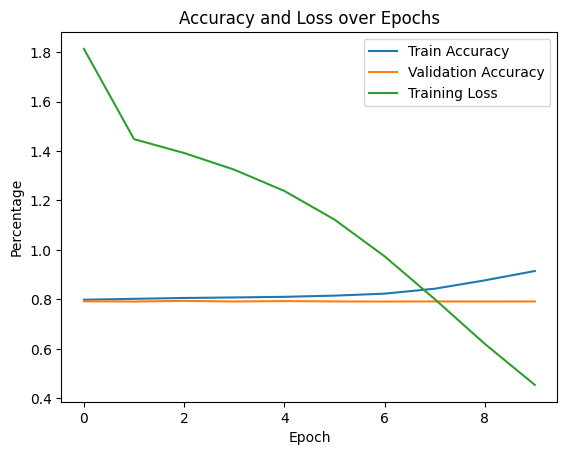

In [49]:
# Plotting the training history to visualize accuracy and loss over epochs

import matplotlib.pyplot as plt

# Plotting training accuracy, validation accuracy, and training loss over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')

# Adding labels and title to the plot
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.title("Accuracy and Loss over Epochs")

# Adding a legend to distinguish between different curves
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Training Loss'])

# Displaying the plot
plt.show()


The plot shows that the training history of the word_prediction_model over the epochs, it displays the changes in validation accuracy, training loss, and train accuracy. 

The train accuracy increases, although it doesn't increases dramatically. It proves that the model is improving its performance on training data.

Next, the validation accuracy shows a slight increase but remains stable, indicating that the model is not significantly overfitting.

The training loss decreases over epochs, shows as a positive sign because the model is learning and adjusting its parameters to reduce the difference between predicted and actual values on training data.

# **Testing the model on test data**

In [50]:
# Importing necessary modules and classes from Keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences

# Tokenize the test_data using the same tokenizer
test_sequences = [sentence.split() for sentence in test_data]

# Convert sentences to sequences using the word_index from the training data
test_malay_sequences = malay_tokenizer.texts_to_sequences(test_data)

# Pad the test sequences into uniform length using the max_length from the training data
test_malay_sequences_array = pad_sequences(test_malay_sequences, maxlen=max_length)

# Display the top ten lines of your preprocessed test data
print("\nTop ten lines of preprocessed test data:")
for i in range(n):
    print(test_data[i])

# Function to generate testing data for word prediction
def generate_testing_data(sequences, n):
    x_data = []
    y_data = []

    for sequence in sequences:
        for i in range(len(sequence) - n):
            x_data.append(sequence[i:i+n])
            y_data.append(sequence[i+n])

    return np.array(x_data), np.array(y_data)

# Set the value of n (number of previous words to consider)
n = 10  



Top ten lines of preprocessed test data:
Ganja makan ialah sebarang produk makanan yang terdiri dari bahan-bahan kimia terkandung dalam ganja khususnya tetrahidrokanabinol ("tetrahydrocannabinol", THC). Makanan ini seringkali diambil santap untuk tujuan perubatan dan rekreasional. Ciri cannabinoid yang berlemak dan beralkohol menyebabkan ganja harus dimasak dengan salah satu dari dua bahan ini agar ia dapat diserap bahan makanan lain sambil mengaktifkan kesan psikoaktif mereka.
Pada penyajiannya, ganja atau sarinya harus dipanaskan untuk menghasilkan dekarboksilasi dari kanabinoid ("cannabinoid"), asid tetrahidrokanabinolik ("tetrahydrocannabinolic acid", THCA) mengubahnya menjadi THC psikoaktif.
Pembuatan minyak dari sari ganja telah dikenal dari zaman kuno, di mana manuskrip-manuskrip bahasa Sanskrit dari India mengharuskan agar ganja dimasukkan dalam minyak sapi sebelum dicampur dengan bahan lainnya. Membuat teh dengan merebus ganja dalam air merupakan sebuah cara yang sangat tak l

In [51]:
# Generate testing data for word prediction
test_x_data, test_y_data = generate_testing_data(test_malay_sequences_array, n)


In [52]:
# LSTM-based word prediction model
word_prediction_model = Sequential()
word_prediction_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=n))
word_prediction_model.add(LSTM(128)) 
word_prediction_model.add(Dense(vocab_size, activation='softmax'))
word_prediction_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [53]:
# Evaluate the model on the test data
loss, accuracy = word_prediction_model.evaluate(test_x_data, test_y_data, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2556/2556 [==============================] - 36s 14ms/step - loss: 9.2098 - accuracy: 1.2228e-05
Test Loss: 9.209794044494629
Test Accuracy: 1.2227928891661577e-05


# **Testing Model on Validation Dataset**

The word_prediction_model was tested on the valid_data using n=10. The prediction was produced for each input sequence, and the output includes the input sequence along with the predicted word.

In [54]:
# Tokenization of validation data
valid_sequences = [sentence.split() for sentence in valid_data]

# Convert sentences to sequences using the word_index from the training data
valid_malay_sequences = malay_tokenizer.texts_to_sequences(valid_data)

# Pad the sequences into uniform length using the max_length from the training data
valid_pad_malay_sequences = pad_sequences(valid_malay_sequences, maxlen=max_length)
print("Valid Malay Sequences (padded): ", valid_pad_malay_sequences)

# Display the top ten lines of your preprocessed validation data
print("\nTop ten lines of preprocessed validation data:")
for i in range(n):
    print(valid_data[i])

# Convert padded valid_malay_sequences to a NumPy array
valid_malay_sequences_array = np.array(valid_pad_malay_sequences)
print("Valid Malay Sequences (as NumPy array): ", valid_malay_sequences_array)


Valid Malay Sequences (padded):  [[  0   0   0 ...  32   1   1]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ...   1  32   1]
 ...
 [  0   0   0 ...   4 177 224]
 [  0   0   0 ...  32   1   1]
 [  0   0   0 ...   0   0   1]]

Top ten lines of preprocessed validation data:
Negeri Kedah merupakan sebuah negeri yang terkenal sebagai sebuah negeri pertanian yang maju di Malaysia, terutamanya sebagai pengeluar padi terbesar, menghasilkan 70% pengeluaran hasil padi.2017 . Salah satu makanan tradisi istimewanya adalah laksa Kedah.
Poskod.
Poskod yang digunakan di Kampung Hijrah, Kuala Nerang, Kedah adalah 06300.

Kampung Jelutong:
Kampung Jelutong boleh merujuk pada beberapa perkara, antaranya adalah:-

Kampung Jelutong, Kuala Nerang:
Kampung Jelutong merupakan sebuah kampung yang terletak di Kuala Nerang, dalam Kedah, iaitu sebuah negeri di Malaysia.
Negeri Kedah Darul Aman, iaitu negeri di utara di Malaysia, dan yang bersempadan dengan negara Thailand di timur lautnya, dan bersempadan denga

In [55]:
# Generate validation data for word prediction without labels
valid_x_data, _ = generate_word_prediction_data(valid_malay_sequences, n)

# Get predictions from the model
predictions = word_prediction_model.predict(valid_x_data)

# You can use the predictions for further analysis or post-processing
# For example, you can get the index of the predicted word with the highest probability
predicted_indices = np.argmax(predictions, axis=1)

# Convert indices back to words using the tokenizer
predicted_words = [malay_tokenizer.index_word.get(idx, "<UNK>") for idx in predicted_indices]



131/131 [==============================] - 2s 13ms/step


In [56]:
# Assuming valid_x_data contains the input sequences for validation
predictions = word_prediction_model.predict(valid_x_data)

for i in range(min(5, len(valid_x_data))):
    input_sequence = " ".join([malay_tokenizer.index_word.get(idx, "<UNK>") for idx in valid_x_data[i]])
    predicted_index = np.argmax(predictions[i])
    predicted_word = malay_tokenizer.index_word.get(predicted_index, "<UNK>")
    print(f"Input: {input_sequence}, Predicted: {predicted_word}")


131/131 [==============================] - 2s 13ms/step
Input: negeri <UNK> merupakan sebuah negeri yang terkenal sebagai sebuah negeri, Predicted: <UNK>
Input: <UNK> merupakan sebuah negeri yang terkenal sebagai sebuah negeri pertanian, Predicted: <UNK>
Input: merupakan sebuah negeri yang terkenal sebagai sebuah negeri pertanian yang, Predicted: kota
Input: sebuah negeri yang terkenal sebagai sebuah negeri pertanian yang <UNK>, Predicted: <UNK>
Input: negeri yang terkenal sebagai sebuah negeri pertanian yang <UNK> di, Predicted: <UNK>


# **Loading the saved model**

In [57]:
# Load the best-performing word prediction model from the saved file
best_model = tf.keras.models.load_model("/kaggle/working/best_word_prediction_model.h5")

# Evaluate the model on the test data
loss, accuracy = best_model.evaluate(test_x_data, test_y_data, verbose=1)


2556/2556 [==============================] - 75s 29ms/step - loss: 1.4700 - accuracy: 0.8321


# Reference
Tokenizing text in Python
https://developer.ibm.com/tutorials/awb-tokenizing-text-in-python/

Word2Vec Neural Network from scratch
https://towardsdatascience.com/skip-gram-neural-network-from-scratch-485f2e688238

Keras - Model Evaluation and Model Prediction
https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm